---

# Statistical Testing

By: Tomás Urdiales

-> Notebook for running relevant statistical tests on the target time-series and on forecast residuals.

##### Libraries

In [ ]:
# Change notebook CWD to the project's root, so python can read from src:
import os
os.chdir("..")

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge

from sklearn.metrics import mean_absolute_error, mean_squared_error

from src import utils, my_plots
from src.cross_validation import backtesting_CV
from src.join_qh_min_data import join_qh_min_data

##### Parameters

In [2]:
CWD = utils.get_root_dir()

# To not use darts plotting style:
plt.style.use('default')

DPI = 150 # (pixel density for figures)
ELIA_ORANGE = (250/256, 115/256, 1/256) # RGB

##### Load data

In [3]:
qh = utils.load_qh_historical_data().loc["2021":"2022"]
minute = utils.load_min_historical_data().loc["2021":"2022"]
ems = utils.load_ems_historical_data().loc["2021":"2022"]
xb = utils.load_xb_historical_data().loc["2021":"2022"]

# Additional features:
ems.insert(1, "elia_sum_prod_mw_cm-value-diff", ems["elia_sum_prod_mw_cm-value"].diff())
minute["rolling_15"] = minute["system_imbalance"].rolling(window=15, center=False).mean()
minute["rolling_60"] = minute["system_imbalance"].rolling(window=60, center=False).mean()

# Add in XB data:
qh = qh.assign(xb_day_ahead = xb["xb_day_ahead"])
qh = qh.assign(xb_intraday = xb["xb_intraday"])
qh = qh.assign(xb_grand_total = xb["xb_grand_total"])
qh = qh.assign(xb_physical_accounting_net_import_mw = xb["xb_physical_accounting_net_import_mw"])

---

## Set up data matrix

In [4]:
MINUTE = "all"

qh_parameters = {
    "system_imbalance_cum15": {
        "lags": [1, -1, -2, -3, -4, -5, -95, -94, -93, -96, -671, -670, -669]},

    "xb_day_ahead": {
        "lags": [5, 1, 0, -4]},
    "xb_intraday": {
        "lags": [5, 1, 0, -4]},
    "xb_grand_total": {
        "lags": [5, 1, 0, -4]},
    "xb_physical_accounting_net_import_mw": {
        "lags": [-1, -2, -3, -4]},

    "total_load_last_mw": {
        "lags": [3, 2, 1, 0, -1, -2, -3, -4]},

    "nrv_rt": {
        "lags": [-1, -2, -3, -4, -95, -671]},
    "load_rt_mw": {
        "lags": [-1, -2, -3, -4, -95, -671]},
    "wind_rt_mw": {
        "lags": [-1, -2, -3, -4]},
}

minute_parameters = {
    "system_imbalance": {
        "lags": [0, -1, -4]},

    "net_regulation_volume": {
        "lags": [0, -1, -2, -3, -4]},
    "rolling_15": {
        "lags": [0]},
    "rolling_60": {
        "lags": [0]},
}

# Prepare training dataframe:
df = join_qh_min_data(
    qh_data=qh,
    minute_data=minute,
    qh_parameters=qh_parameters,
    minute_parameters=minute_parameters,
    minute=MINUTE,
    # ems_data=ems,
    # ems_parameters=ems_parameters,
)
TARGET = "system_imbalance_cum15_from_qh_plus_1"
FEATURES = [feature for feature in df.columns if feature != TARGET]

df = df.dropna()

# Set up splits and model features:
tscv = TimeSeriesSplit(
    n_splits=52 * 7 // 4,
    max_train_size=4 * 24 * 7 * 20,
    test_size=4 * 24 * 4,
    gap=0
)

---

## Analysing residuals

In [10]:
from sklearn.linear_model import Ridge
model_ridge = Ridge(
    alpha=0.5,
    tol=1e-4,
    max_iter=1000,
    solver="auto",
)

# Choose model to fit:
# model_pipeline = make_pipeline(StandardScaler(), LinearRegression(n_jobs=-1))
model_pipeline = make_pipeline(StandardScaler(), model_ridge)

full_fit = model_pipeline.fit(df[FEATURES].loc["2022"], df[TARGET].loc["2022"])
residuals = df[TARGET].loc["2022"] - full_fit.predict(df[FEATURES].loc["2022"])

In [11]:
total_mae = mean_absolute_error(df[TARGET].loc["2022"], full_fit.predict(df[FEATURES].loc["2022"]))

total_rmse = np.sqrt(mean_squared_error(df[TARGET].loc["2022"], full_fit.predict(df[FEATURES].loc["2022"])))
print(f"Total MAE: {total_mae:.2f}MW | Total RMSE: {total_rmse:.2f}MW")

Total MAE: 102.47MW | Total RMSE: 135.36MW


count    3.492600e+04
mean     1.647069e-14
std      1.353603e+02
min     -9.867842e+02
25%     -8.000361e+01
50%      3.279694e+00
75%      8.122045e+01
max      9.751010e+02
Name: system_imbalance_cum15_from_qh_plus_1, dtype: float64

The residuals have zero mean, so the forecasts are unbiased ✅
Residuals are not a perfect Gaussian distribution around zero, but close.


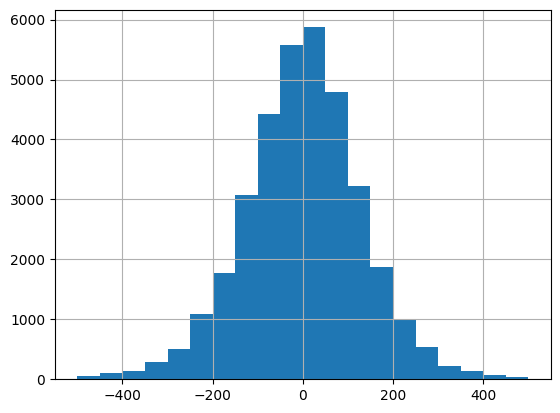

In [12]:
print(residuals.describe())
print("\nThe residuals have zero mean, so the forecasts are unbiased ✅")

# residuals.hist(bins=np.linspace(-500, 500, 41));
residuals.hist(bins=np.linspace(-500, 500, 21));
# residuals.hist(bins=np.linspace(-500, 500, 9));
print("Residuals are not a perfect Gaussian distribution around zero, but close.")

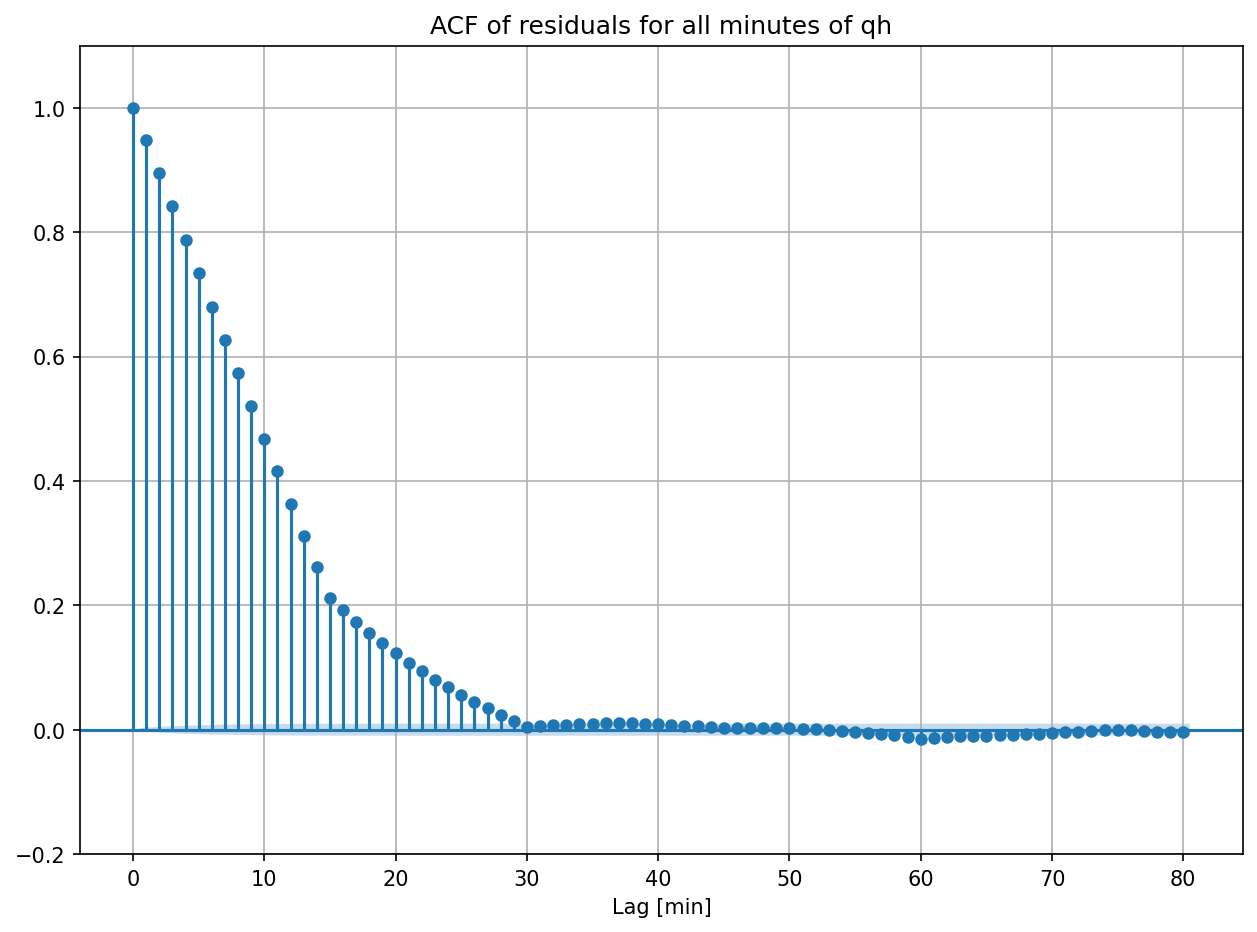

In [8]:
import statsmodels.api as sm

fig, ax = plt.subplots(figsize=(10, 7), dpi=DPI)
sm.graphics.tsa.plot_acf(residuals, alpha=.05, lags=80,
                         ax=ax, title="ACF of residuals for all minutes of qh")
plt.ylim([-0.2,1.1])
plt.xlabel('Lag [min]')
plt.grid()
plt.show()

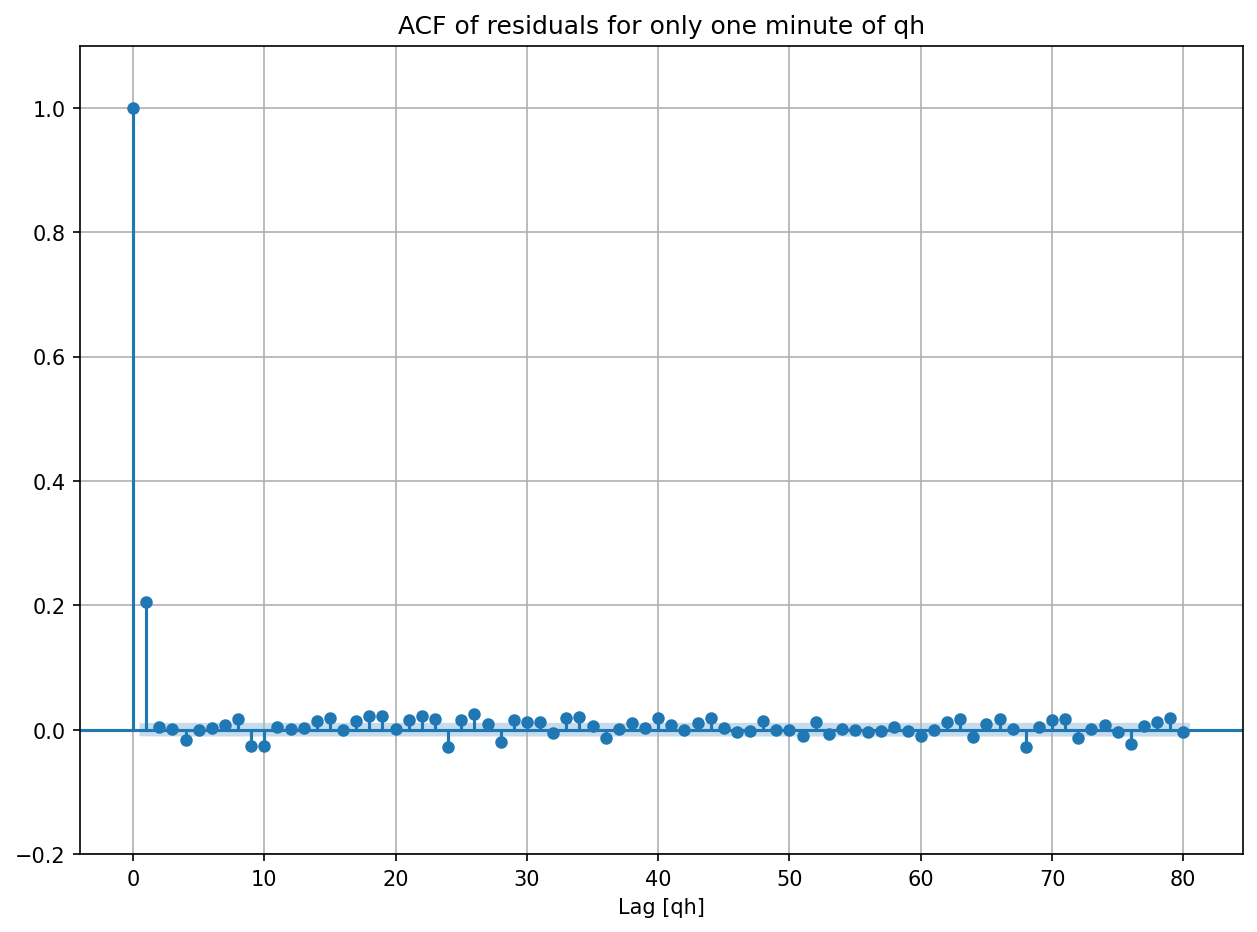

In [13]:
import statsmodels.api as sm

fig, ax = plt.subplots(figsize=(10, 7), dpi=DPI)
sm.graphics.tsa.plot_acf(residuals, alpha=.05, lags=80,
                         ax=ax, title="ACF of residuals for only one minute of qh")
plt.ylim([-0.2,1.1])
plt.xlabel('Lag [qh]')
plt.grid()
plt.show()

---

## Augmented Dickey-Fuller test

In [5]:
# On all historical records of system_imbalance_cum15:
from statsmodels.tsa.stattools import adfuller

ADF = adfuller(
    x=qh["system_imbalance_cum15"].dropna(),
    regression="ct",
    autolag="AIC",
)

print("ADF Statistic: %f" % ADF[0])
print("p-value: %f" % ADF[1])
print("Critical Values:")
for key, value in ADF[4].items():
    print("\t%s: %.3f" % (key, value))

print("\nWe reject the null hypothesis!\nThus, the time-series is most probably stationary")
print("*The strongly negative ADF statistic suggests that we can reject the null hypothesis with a significance level of less than 1% (i.e. a low probability that the result is a statistical fluke).")

ADF Statistic: -25.675932
p-value: 0.000000
Critical Values:
	1%: -3.959
	5%: -3.411
	10%: -3.127

We reject the null hypothesis!
Thus, the time-series is most probably stationary
*The strongly negative ADF statistic suggests that we can reject the null hypothesis with a significance level of less than 1% (i.e. a low probability that the result is a statistical fluke).


In [7]:
# On all historical records of si_MW:
from statsmodels.tsa.stattools import adfuller

ADF = adfuller(
    x=qh["si_mw"],
    regression="ct",
    autolag="AIC",
)

print("ADF Statistic: %f" % ADF[0])
print("p-value: %f" % ADF[1])
print("Critical Values:")
for key, value in ADF[4].items():
    print("\t%s: %.3f" % (key, value))

print("\nWe reject the null hypothesis!\nThus, the time-series is most probably stationary.")
print("*The strongly negative ADF statistic suggests that we can reject the null hypothesis with a significance level of less than 1% (i.e. a low probability that the result is a statistical fluke).")

ADF Statistic: -25.867955
p-value: 0.000000
Critical Values:
	1%: -3.959
	5%: -3.411
	10%: -3.127

We reject the null hypothesis!
Thus, the time-series is most probably stationary.
*The strongly negative ADF statistic suggests that we can reject the null hypothesis with a significance level of less than 1% (i.e. a low probability that the result is a statistical fluke).


In [ ]:
# On minute-wise SI:
from statsmodels.tsa.stattools import adfuller

ADF = adfuller(
    x=minute["system_imbalance"].loc["2022"].dropna(),
    regression="ct",
    autolag="AIC",
)

print("ADF Statistic: %f" % ADF[0])
print("p-value: %f" % ADF[1])
print("Critical Values:")
for key, value in ADF[4].items():
    print("\t%s: %.3f" % (key, value))

print("\nWe reject the null hypothesis!\nThus, the time-series is most probably stationary.")
print("*The strongly negative ADF statistic suggests that we can reject the null hypothesis with a significance level of less than 1% (i.e. a low probability that the result is a statistical fluke).")

ADF Statistic: -47.296631
p-value: 0.000000
Critical Values:
	1%: -3.959
	5%: -3.410
	10%: -3.127

We reject the null hypothesis!
Thus, the time-series is most probably stationary.
*The strongly negative ADF statistic suggests that we can reject the null hypothesis with a significance level of less than 1% (i.e. a low probability that the result is a statistical fluke).


In [ ]:
# On residuals:
from statsmodels.tsa.stattools import adfuller

ADF = adfuller(
    x=residuals,
    regression="ct",
    autolag="AIC",
)

print("ADF Statistic: %f" % ADF[0])
print("p-value: %f" % ADF[1])
print("Critical Values:")
for key, value in ADF[4].items():
    print("\t%s: %.3f" % (key, value))

ADF Statistic: -67.417540
p-value: 0.000000
Critical Values:
	1%: -3.959
	5%: -3.410
	10%: -3.127


---

## Diebold-Mariano test

In [4]:
from scipy.stats import t

def DM_test(
    y_test: pd.Series,
    y_pred_1: pd.Series,
    y_pred_2: pd.Series,
    h: int = 1,
    harvey_adj: bool = True):
    """
    -> Performs the Diebold-Mariano test to check for statistical significance in difference between two forecasts.

    Arguments:
        y_test -> real forecasted time-series
        y_pred_1 -> first forecast to compare
        y_pred_2 -> second forecast to compare
        h -> forecast horizon
        harvey_adj -> Harvey adjustment (leave as True)
    """

    e1_lst = []
    e2_lst = []
    d_lst = []

    y_test = y_test.tolist()
    y_pred_1 = y_pred_1.tolist()
    y_pred_2 = y_pred_2.tolist()

    # Length of forecasts
    T = float(len(y_test))

    # Construct loss differential according to error criterion (MSE)
    for real, p1, p2 in zip(y_test, y_pred_1, y_pred_2):
        e1_lst.append((real - p1)**2)
        e2_lst.append((real - p2)**2)
    for e1, e2 in zip(e1_lst, e2_lst):
        d_lst.append(e1 - e2)

    # Mean of loss differential
    mean_d = pd.Series(d_lst).mean()

    # Calculate autocovariance 
    def autocovariance(Xi, N, k, Xs):
        autoCov = 0
        T = float(N)
        for i in np.arange(0, N-k):
            autoCov += ((Xi[i+k])-Xs)*(Xi[i]-Xs)
        return (1/(T))*autoCov
    
    # Calculate the denominator of DM stat
    gamma = []
    for lag in range(0, h):
        gamma.append(autocovariance(d_lst, len(d_lst), lag, mean_d))  # 0, 1, 2
    V_d = (gamma[0] + 2*sum(gamma[1:]))/T
    
    # Calculate DM stat
    DM_stat = V_d**(-0.5)*mean_d

    # Calculate and apply Harvey adjustement
    # It applies a correction for small sample
    if harvey_adj is True:
        harvey_adj = ((T+1-2*h+h*(h-1)/T)/T)**(0.5)
        DM_stat = harvey_adj*DM_stat 

    # Calculate p-value
    p_value = 2*t.cdf(-abs(DM_stat), df=T - 1)

    print(f"DM Statistic: {DM_stat :.4f} | p-value: {p_value :.4f}")

In [5]:
ensemble = pd.read_pickle("ensemble.pkl")

# Run test:
print("Between linear and mlp:")
DM_test(ensemble.y_test, ensemble.linear, ensemble.mlp, h=30, harvey_adj=True)
print("\nBetween linear and huber:")
DM_test(ensemble.y_test, ensemble.linear, ensemble.huber, h=30, harvey_adj=True)
print("\nBetween linear and forest")
DM_test(ensemble.y_test, ensemble.linear, ensemble.forest, h=30, harvey_adj=True)
print("\nBetween linear and svr:")
DM_test(ensemble.y_test, ensemble.linear, ensemble.svr, h=30, harvey_adj=True)

Between linear and mlp:
DM Statistic: 10.8670 | p-value: 0.0000

Between linear and huber:
DM Statistic: -1.8396 | p-value: 0.0658

Between linear and forest
DM Statistic: -10.1277 | p-value: 0.0000

Between linear and svr:
DM Statistic: -1.6376 | p-value: 0.1015


In [11]:
# Recover legacy model results:
MINUTE = "all"

qh_parameters = {
    "system_imbalance_cum15": {
        "lags": [1]},
    "si_mw": {
        "lags": [-1, -2, -3, -4]},
    "load_id_mw": {
        "lags": [3, 2, 1, 0, -1, -2, -3, -4]},
    "nrv_rt": {
        "lags": [-1, -2, -3, -4]},
}

minute_parameters = {
    "system_imbalance": {
        "lags": [0, -1, -2, -3]},
    "net_regulation_volume": {
        "lags": [0, -1, -2, -3]},
}

# Prepare training dataframe:d
df = join_qh_min_data(
    qh_data=qh,
    minute_data=minute,
    qh_parameters=qh_parameters,
    minute_parameters=minute_parameters,
    minute=MINUTE,
)
TARGET = "system_imbalance_cum15_from_qh_plus_1"
FEATURES = [feature for feature in df.columns if feature != TARGET]

df = df.dropna()

# Set up splits and model features:
tscv = TimeSeriesSplit(n_splits=52 * 7 // 4, max_train_size=15 * 4 * 24 * 7 * 20, test_size=15 * 4 * 24 * 4, gap=0)

# Cross-validation:
results_linear = backtesting_CV(model=LinearRegression(),
                                data=df,
                                time_splits=tscv,
                                features=FEATURES,
                                target=TARGET,
                                progress_bar=True,
                                verbose=False
                                )

MODEL: LinearRegression
Time configuration: 91 splits, 4 testing days, 20 training weeks. Total predicted time: 364 days.



100%|██████████| 91/91 [00:30<00:00,  2.95it/s]



Train set average error:
MAE: 107.14MW | RMSE: 142.50MW
Test set average error:
MAE: 109.96MW | RMSE: 146.13MW | MASE: 0.7335 | P90 Error: 232.73MW | Max Error: 1106.8 (2022-09-06 21:15:00+02:00)
Time elapsed: 31.02s | Time per split: ~0.34s



In [26]:
index_intersection = results_linear[0].index.min(), ensemble.index.max()

ensemble = ensemble.loc[index_intersection[0] : index_intersection[1]]
results_linear[0] = results_linear[0].loc[index_intersection[0] : index_intersection[1]]

print("\nBetween legacy linear and linear:")
DM_test(ensemble.y_test, results_linear[0].y_pred, ensemble.linear, h=30, harvey_adj=True)


Between legacy linear and linear:
DM Statistic: 34.7721 | p-value: 0.0000
